# IF3070 Foundations of Artificial Intelligence | Tugas Besar 2


Group Number: 15

Group Members:
- Akmal Galih Aji Suseno (18222046)
- Raizan Iqbal Resi (18222068)
- Muhammad Kevinza Faiz (18222072)
- Muhammad Raihan Ariffianto (18222092)

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.preprocessing import RobustScaler


from sklearn.preprocessing import RobustScaler, MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

from typing import List
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

## Import Dataset

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=1k2r4dh87_wvDFu2L4EMa372ZSzS0AENh') # Real

continuous_columns = [col for col in df.columns if df[col].nunique() > 2]
categorical_columns = [col for col in df.columns if df[col].nunique() <= 2]

# 1. Split Training Set and Validation Set


In [ ]:
train_set, val_set = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['label'])

# 2. Data Cleaning and Preprocessing


## A. Data Cleaning

### I. Handling Missing Data


#### Cross Filling

In [ ]:
def process_and_fill_missing(df):
    ret = df.copy()

    # Process 'URLLength'
    ret['URLLength'] = ret['URL'].apply(lambda url: len(url) if isinstance(url, str) else None)

    # Process 'Domain' and 'DomainLength'
    ret.loc[ret['Domain'].isna() & ret['URL'].notna(), 'Domain'] = ret['URL'].apply(
        lambda url: re.search(r'https?://(?:www\.)?([^/]+)', url).group(1) if isinstance(url, str) and re.search(r'https?://(?:www\.)?([^/]+)', url) else None
    )
    ret['DomainLength'] = ret['Domain'].apply(lambda x: len(x) if isinstance(x, str) else None)

    # Process 'TLD' and 'TLDLength'
    ret.loc[ret['TLD'].isna() & ret['Domain'].notna(), 'TLD'] = ret['Domain'].apply(
        lambda domain: domain.split('.')[-1] if isinstance(domain, str) else None
    )
    ret['TLDLength'] = ret.apply(
        lambda row: len(row['TLD']) if pd.notna(row['TLD']) and pd.isna(row['TLDLength']) else row['TLDLength'], axis=1
    )

    # Process 'IsDomainIP'
    def is_ip(value):
        if pd.isna(value):
            return False
        ip_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
        ipv6_pattern = r'^(([0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,7}:|' \
                       r'([0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|' \
                       r'([0-9a-fA-F]{1,4}:){1,5}(:[0-9a-fA-F]{1,4}){1,2}|' \
                       r'([0-9a-fA-F]{1,4}:){1,4}(:[0-9a-fA-F]{1,4}){1,3}|' \
                       r'([0-9a-fA-F]{1,4}:){1,3}(:[0-9a-fA-F]{1,4}){1,4}|' \
                       r'([0-9a-fA-F]{1,4}:){1,2}(:[0-9a-fA-F]{1,4}){1,5}|' \
                       r'[0-9a-fA-F]{1,4}:((:[0-9a-fA-F]{1,4}){1,6})|' \
                       r':((:[0-9a-fA-F]{1,4}){1,7}|:)|' \
                       r'fe80:(:[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|' \
                       r'::(ffff(:0{1,4}){0,1}:){0,1}' \
                       r'(([0-9]{1,3}\.){3}[0-9]{1,3})|' \
                       r'([0-9a-fA-F]{1,4}:){1,4}:' \
                       r'(([0-9]{1,3}\.){3}[0-9]{1,3}))$'
        return bool(re.match(ip_pattern, value)) or bool(re.match(ipv6_pattern, value))

    ret['IsDomainIP'] = ret.apply(
        lambda row: True if is_ip(row['Domain']) or is_ip(row['URL']) else False, axis=1
    )
    def autoImputer(row):
        if pd.notna(row['URL']):
            url = row['URL']
            url_length = len(url)
            letters = sum(1 for char in url if char.isalpha())
            digits = sum(1 for char in url if char.isdigit())
            equals = url.count('=')
            q_marks = url.count('?')
            ampersands = url.count('&')
            special_chars = sum(1 for char in url if char in string.punctuation and char not in ['=', '?', '&'])

            row['NoOfLettersInURL'] = letters
            row['LetterRatioInURL'] = letters / url_length if url_length > 0 else 0
            row['NoOfDegitsInURL'] = digits
            row['DegitRatioInURL'] = digits / url_length if url_length > 0 else 0
            row['NoOfEqualsInURL'] = equals
            row['NoOfQMarkInURL'] = q_marks
            row['NoOfAmpersandInURL'] = ampersands
            row['NoOfOtherSpecialCharsInURL'] = special_chars
            row['SpacialCharRatioInURL'] = (letters + digits + special_chars) / url_length if url_length > 0 else 0
            row['IsHTTPS'] = 1 if url.lower().startswith('https://') else 0
        if pd.isna(row['NoOfSubDomain']):
            if pd.notna(row['Domain']):
                row['NoOfSubDomain'] = len(row['Domain'].split('.')) - 1
        if row.get('HasObfuscation', 0) == 0:
            row['NoOfObfuscatedChar'] = 0
        elif pd.isna(row['NoOfObfuscatedChar']):
            if pd.notna(row['URL']):
                row['NoOfObfuscatedChar'] = row['URL'].count('%') * 3
        if pd.isna(row['ObfuscationRatio']):
            if pd.notna(row['NoOfObfuscatedChar']) and pd.notna(row['URLLength']):
                row['ObfuscationRatio'] = row['NoOfObfuscatedChar'] / row['URLLength']
        if pd.isna(row['URLTitleMatchScore']):
            if pd.notna(row['DomainTitleMatchScore']):
                row['URLTitleMatchScore'] = row['DomainTitleMatchScore']
            else:
                row['URLTitleMatchScore'] = 0

        return row

    ret = ret.apply(autoImputer, axis=1)
    ret = ret.select_dtypes(exclude=['object'])

    return ret


#### Imputing

In [ ]:
def impute_continuous_columns(df):
    continuous_columns = [col for col in df.columns if df[col].nunique() > 2]
    continuous_df = df[continuous_columns]

    mode_imputer = SimpleImputer(strategy='median')

    continuous_imputed = pd.DataFrame(
        mode_imputer.fit_transform(continuous_df),
        columns=continuous_columns
    )

    df[continuous_columns] = continuous_imputed

    return df

In [ ]:
def impute_categorical_columns(df):
    categorical_columns = [col for col in df.columns if df[col].nunique() == 2]

    encodings = {}
    for col in categorical_columns:
        unique_values = df[col].dropna().unique()
        encodings[col] = {value: idx for idx, value in enumerate(unique_values)}
        df[col] = df[col].map(encodings[col])

    knn_imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
    categorical_imputed = pd.DataFrame(
        knn_imputer.fit_transform(df[categorical_columns]),
        columns=categorical_columns
    )

    categorical_imputed = categorical_imputed.round(0).astype(int)

    for col in categorical_columns:
        reverse_mapping = {v: k for k, v in encodings[col].items()}
        categorical_imputed[col] = categorical_imputed[col].map(reverse_mapping)

    df[categorical_columns] = categorical_imputed

    return df

In [ ]:
def imputevalues(df):
  ret = df.copy()
  ret = ret.select_dtypes(exclude=['object'])
  ret = impute_continuous_columns(ret)
  # print("Amount of NaN and Null values in all continuous columns:")
  # print(df[continuous_columns].isnull().sum())
  ret = impute_categorical_columns(ret)

  return ret

### II. Remove Duplicates

In [ ]:
def remove_duplicates(df):
  temp = df.copy()
  temp.drop_duplicates(subset=None, keep='first', inplace=True)
  return temp

### III. Feature Engineering

In [ ]:
def remove_features(df):
    features_to_remove = [
        'Robots', 'NoOfCSS', 'Pay', 'NoOfSelfRef', 'LineOfCode', 'NoOfImage', 'NoOfExternalRef', 'Bank',
        'NoOfiFrame', 'HasPasswordField', 'TLDLegitimateProb',
        'Crypto', 'NoOfEmptyRef', 'NoOfPopup', 'SpacialCharRatioInURL',
        'NoOfURLRedirect', 'NoOfSubDomain', 'LargestLineLength', 'NoOfObfuscatedChar',
        'NoOfSelfRedirect', 'TLDLength', 'ObfuscationRatio',
        'NoOfAmpersandInURL', 'NoOfEqualsInURL', 'NoOfOtherSpecialCharsInURL',
        'CharContinuationRate', 'HasSubmitButton', 'HasFavicon', 'DomainLength',
        'NoOfDegitsInURL', 'NoOfLettersInURL', 'NoOfJS', 'DomainTitleMatchScore'
    ]

    # Remove features from the DataFrame
    df = df.drop(columns=features_to_remove, axis=1)
    return df

## B. Data Preprocessing


### I. Feature Scaling


In [ ]:
def robustScaling(df):
    continuous_columns = [col for col in df.columns if df[col].nunique() > 2 and col != 'id']
    continuous_df = df[continuous_columns]

    robust_scaler = RobustScaler()
    scaled_continuous_df = robust_scaler.fit_transform(continuous_df)

    df[continuous_columns] = scaled_continuous_df

    return df


### II. Handling Imbalanced Dataset


In [ ]:
def apply_smoteenn(df):
    df = df.dropna(how='all')
    X = df.drop(columns=['label'])
    y = df['label']
    smoteenn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smoteenn.fit_resample(X, y)
    df_resampled = pd.concat(
        [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')],
        axis=1
    )
    return df_resampled

# 3. Compile Preprocessing Pipeline

In [ ]:
def data_processing_pipeline(df, train: bool = True):
    print("Jumlah row:", df.shape[0])

    print("Processing and filling missing values...")
    df = process_and_fill_missing(df)

    print("Jumlah row:", df.shape[0])

    print("Removing specified features...")
    df = remove_features(df)

    print("Jumlah row:", df.shape[0])

    print("Imputing values...")
    df = imputevalues(df)

    print("Jumlah row:", df.shape[0])

    print("Removing duplicates...")
    df = remove_duplicates(df)

    print("Jumlah row:", df.shape[0])

    print("Scaling continuous features...")
    df = robustScaling(df)

    print("Jumlah row:", df.shape[0])

    if train == True:
      print("Applying SMOTEENN...")
      df = apply_smoteenn(df)

      print("Jumlah row:", df.shape[0])

    return df


# 4. Modeling and Validation


In [ ]:
train_set_clean = data_processing_pipeline(train_set)
X_train = train_set_clean.drop("label", axis=1)
y_train = train_set_clean["label"]
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

Jumlah row: 112323
Processing and filling missing values...
Jumlah row: 112323
Removing specified features...
Jumlah row: 112323
Imputing values...
Jumlah row: 112323
Removing duplicates...
Jumlah row: 89867
Scaling continuous features...
Jumlah row: 89867
Applying SMOTEENN...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Jumlah row: 89935


In [ ]:
val_set = data_processing_pipeline(val_set)
X_val = val_set.drop("label", axis=1)
y_val = val_set["label"]
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

In [ ]:
X_train = X_train.drop(columns=["id"], axis=1)
X_val = X_val.drop(columns=["id"], axis=1)

## A. KNN

### Built In

#### Euclidean Distance

KNN Accuracy: 0.9899966655551851
KNN Classification Report:
              precision    recall  f1-score   support

         0.0    0.98580   0.99387   0.98982      1467
         1.0    0.99408   0.98629   0.99017      1532

    accuracy                        0.99000      2999
   macro avg    0.98994   0.99008   0.98999      2999
weighted avg    0.99003   0.99000   0.99000      2999



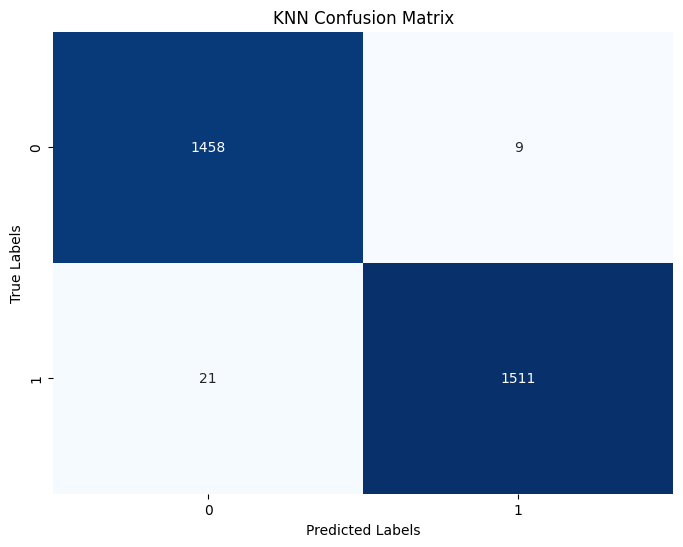

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X_train, y_train.values.ravel())

y_pred_knn = knn_classifier.predict(X_val)

accuracy_knn = accuracy_score(y_val, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("KNN Classification Report:")
print(classification_report(y_val, y_pred_knn, digits=5))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Manhattan Distance

KNN Accuracy: 0.9913304434811604
KNN Classification Report:
              precision    recall  f1-score   support

         0.0    0.99047   0.99182   0.99114      1467
         1.0    0.99216   0.99086   0.99151      1532

    accuracy                        0.99133      2999
   macro avg    0.99131   0.99134   0.99133      2999
weighted avg    0.99133   0.99133   0.99133      2999



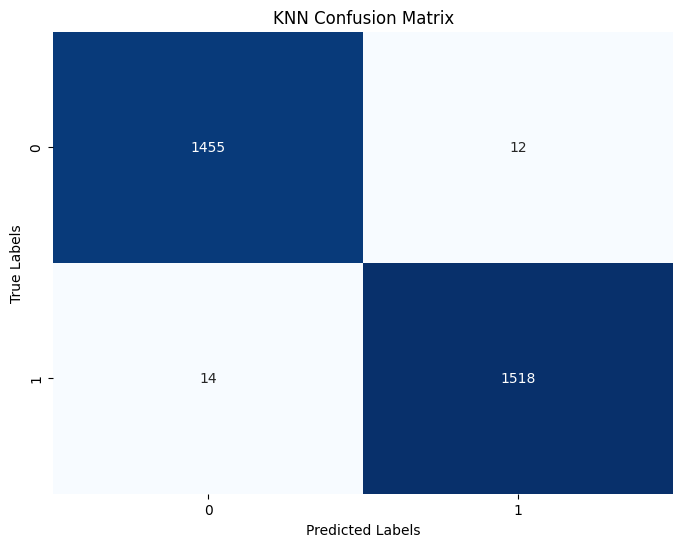

In [ ]:
knn_classifier_mht = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_classifier_mht.fit(X_train, y_train.values.ravel())

y_pred_knn = knn_classifier_mht.predict(X_val)

accuracy_knn = accuracy_score(y_val, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("KNN Classification Report:")
print(classification_report(y_val, y_pred_knn, digits=5))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Minkowski Distance

KNN Accuracy: 0.9879959986662221
KNN Classification Report:
              precision    recall  f1-score   support

         0.0    0.98182   0.99387   0.98780      1467
         1.0    0.99406   0.98238   0.98818      1532

    accuracy                        0.98800      2999
   macro avg    0.98794   0.98812   0.98799      2999
weighted avg    0.98807   0.98800   0.98800      2999



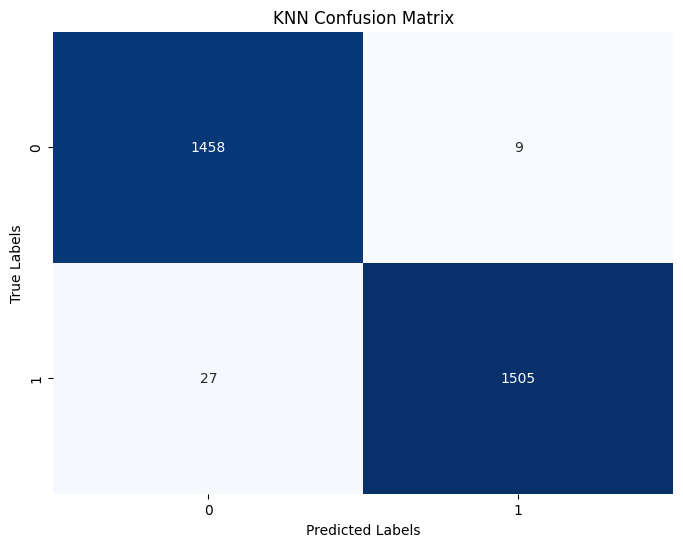

In [ ]:
knn_classifier_mnk = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=3)
knn_classifier_mnk.fit(X_train, y_train.values.ravel())

y_pred_knn = knn_classifier_mnk.predict(X_val)

accuracy_knn = accuracy_score(y_val, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("KNN Classification Report:")
print(classification_report(y_val, y_pred_knn, digits=5))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### KNN from Scratch

In [ ]:
class KNN:
    def __init__(self, k: int = 3, metric: str = 'euclidean', p: int = 2):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.metric = metric
        self.p = p

        valid_metrics = ['euclidean', 'manhattan', 'minkowski']
        if metric not in valid_metrics:
            print("Metric not supported")

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y)

        if len(self.X_train) != len(self.y_train):
            print(f"X train: {len(self.X_train.shape[0])} samples, y_train: {len(self.y_train.shape[0])} samples")
        return self

    def _get_neighbours(self, point: np.ndarray) -> List[int]:
        distances = self._calculate_distance(point, self.X_train)
        indices = np.arange(len(distances))
        sorted_indices = indices[np.argsort(distances)]
        return sorted_indices[:self.k]

    def distance_to_neighbour(self, point: np.ndarray) -> int:
        nearest_indices = self._get_neighbours(point)
        nearest_labels = self.y_train[nearest_indices]
        return Counter(nearest_labels).most_common(1)[0][0]

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.distance_to_neighbour(x) for x in X])

    def _calculate_distance(self, point: np.ndarray, training_points: np.ndarray) -> np.ndarray:
        if self.metric == 'euclidean':
            point = np.array(point, dtype=np.float64).reshape(1, -1)
            return np.sqrt(np.sum((training_points - point) ** 2, axis=1))

        elif self.metric == 'manhattan':
            point = np.array(point, dtype=np.float64).reshape(1, -1)
            return np.sum(np.abs(training_points - point), axis=1)

        elif self.metric == 'minkowski':
            point = np.array(point, dtype=np.float64).reshape(1, -1)
            return np.power(np.sum(np.power(np.abs(training_points - point), self.p), axis=1), 1/self.p)

#### Euclidean Distance

KNN Accuracy: 0.9899966655551851
KNN Classification Report:
              precision    recall  f1-score   support

         0.0    0.98580   0.99387   0.98982      1467
         1.0    0.99408   0.98629   0.99017      1532

    accuracy                        0.99000      2999
   macro avg    0.98994   0.99008   0.98999      2999
weighted avg    0.99003   0.99000   0.99000      2999



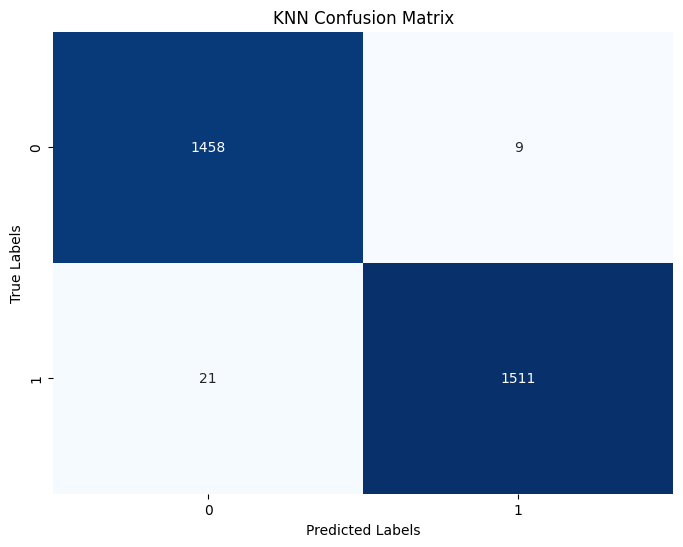

In [ ]:
knn_euclidean = KNN(5, "euclidean")
knn_euclidean.fit(X_train.to_numpy(), y_train.values.ravel())

y_pred_knn = knn_euclidean.predict(X_val.to_numpy())

accuracy_knn = accuracy_score(y_val, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("KNN Classification Report:")
print(classification_report(y_val, y_pred_knn, digits=5))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Manhattan Distance

KNN Accuracy: 0.9913304434811604
KNN Classification Report:
              precision    recall  f1-score   support

         0.0    0.99047   0.99182   0.99114      1467
         1.0    0.99216   0.99086   0.99151      1532

    accuracy                        0.99133      2999
   macro avg    0.99131   0.99134   0.99133      2999
weighted avg    0.99133   0.99133   0.99133      2999



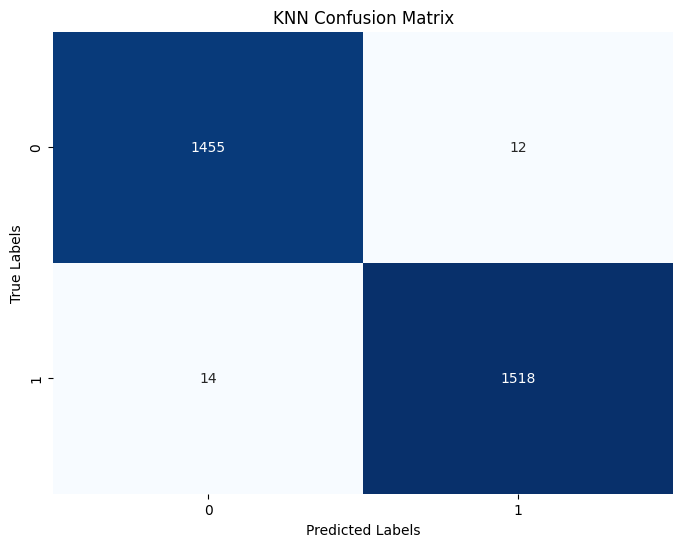

In [ ]:
knn_euclidean = KNN(5, "manhattan")
knn_euclidean.fit(X_train.to_numpy(), y_train.values.ravel())

y_pred_knn = knn_euclidean.predict(X_val.to_numpy())

accuracy_knn = accuracy_score(y_val, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("KNN Classification Report:")
print(classification_report(y_val, y_pred_knn, digits=5))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Minkowski Distance

KNN Accuracy: 0.9879959986662221
KNN Classification Report:
              precision    recall  f1-score   support

         0.0    0.98182   0.99387   0.98780      1467
         1.0    0.99406   0.98238   0.98818      1532

    accuracy                        0.98800      2999
   macro avg    0.98794   0.98812   0.98799      2999
weighted avg    0.98807   0.98800   0.98800      2999



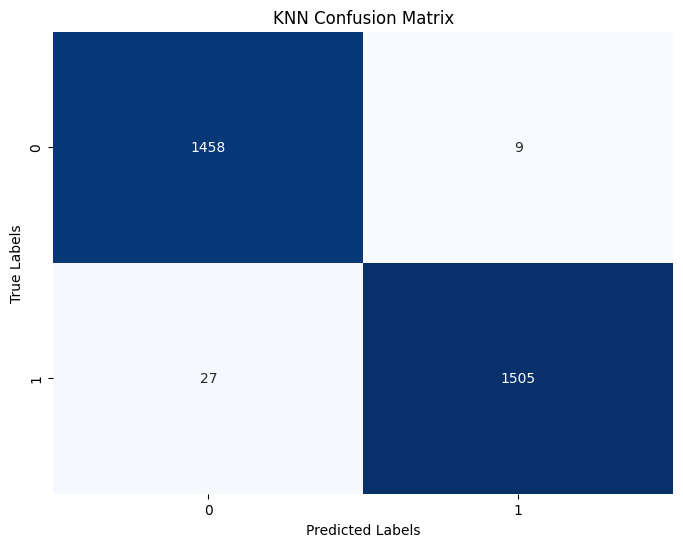

In [ ]:
knn_euclidean = KNN(5, "minkowski", 3)
knn_euclidean.fit(X_train.to_numpy(), y_train.values.ravel())

y_pred_knn = knn_euclidean.predict(X_val.to_numpy())

accuracy_knn = accuracy_score(y_val, y_pred_knn)
print("KNN Accuracy:", accuracy_knn)

print("KNN Classification Report:")
print(classification_report(y_val, y_pred_knn, digits=5))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_knn), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## B. Naive Bayes

#### Built In

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=5))

Accuracy: 0.9556518839613204
              precision    recall  f1-score   support

         0.0    0.99925   0.91002   0.95255      1467
         1.0    0.92063   0.99935   0.95837      1532

    accuracy                        0.95565      2999
   macro avg    0.95994   0.95468   0.95546      2999
weighted avg    0.95909   0.95565   0.95552      2999



#### GNB from Scratch

In [ ]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y)

        self.classes = np.unique(y)
        self.parameters = {}

        for cls in self.classes:
            X_cls = X[y == cls]
            self.parameters[cls] = {
                'mean': X_cls.mean(axis=0),
                'var': X_cls.var(axis=0) + 1e-6,
                'prior': len(X_cls) / len(X)
            }

    def prob(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mean) ** 2 / (2 * var))

    def predict(self, X):
        X = np.array(X, dtype=float)

        y_pred = []
        for x in X:
            posteriors = []
            for cls in self.classes:
                params = self.parameters[cls]
                posterior = np.log(params['prior']) + np.sum(np.log(self.prob(x, params['mean'], params['var'])))
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

In [ ]:
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, digits=5))

Accuracy: 0.9593197732577526

Classification Report:

              precision    recall  f1-score   support

         0.0    0.99926   0.91752   0.95665      1467
         1.0    0.92676   0.99935   0.96168      1532

    accuracy                        0.95932      2999
   macro avg    0.96301   0.95843   0.95916      2999
weighted avg    0.96222   0.95932   0.95922      2999



<ipython-input-72-6e5036b51ecb>:29: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.prob(x, params['mean'], params['var'])))


## D. Submission


In [ ]:
# test = pd.read_csv('https://drive.google.com/uc?id=1Jk7SrEuVXty_3UldvFU3CtrOziAJA4uu')
test = pd.read_csv('test.csv')

In [ ]:
test = data_processing_pipeline(test, False)

# pred_test = test.drop(columns=["id"], axis=1)

knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier.fit(X_train, y_train.values.ravel())

submission = knn_classifier.predict(pred_test)

submission_df = pd.DataFrame({
    'id': test['id'].astype(int),
    'label': submission.astype(int)
})

submission_df = submission_df.set_index('id')

submission_df.to_csv("submission_df.csv")

# 6. Error Analysis


# **KNN Error Analysis**

Here are the performance gaps grouped by distance metric between our KNN machine and Scikit-learn’s implementation:
1. Minkowski Distance
	-	Macro Average F1-Score Gap: -0.203%
2. Manhattan Distance
	-	Macro Average F1-Score Gap: -0.009%
3. Euclidean Distance
	-	Macro Average F1-Score Gap: -0.057%

Observations:
1.	Manhattan Distance shows the smallest overall gaps, indicating it aligns closely with Scikit-learn’s results.
2.	Minkowski Distance has the largest gaps, particularly in recall for Class 1 and F1-scores, suggesting possible implementation-specific differences.
3.	Euclidean Distance falls in the middle, with relatively small gaps but slight issues with Class 0 precision and Class 1 recall.


The gaps might be occured because some factors:
1. Numerical Precision:

  Scikit-learn uses optimized numerical libraries (e.g., Cython, NumPy) with high precision for distance calculations. Small rounding errors in distance metrics (especially in Minkowski or Euclidean) can change neighbor rankings. Therefore, Small variations in distances can cause slightly different neighbor selection, affecting precision, recall, and F1-score for certain classes.

2. KD-Tree Efficienciness

  Even both our implementations and Scikit-learn use KD-Trees, Scikit-learn’s KD-Tree is heavily optimized for
  - Balanced splits: Ensuring better neighbor search efficiency.
  - Edge-case handling: Managing tie distances, near-boundary points, or points equidistant from multiple neighbors.

  Particularly noticeable in metrics like recall and F1-score where false positives/negatives play a significant role.

3. Distance in metric implementation:

  Minkowski (p=3) is more complex and sensitive to numerical precision due to its cubic power. Even small differences in computation (e.g., library vs. custom power functions) can cause neighbor mismatches. This is why, Minkowski shows the largest gaps, particularly for Class 1 recall and macro-average F1-scores.

4. Parallelization and Efficiency

  Scikit-learn uses parallelized operations for KD-Tree queries, distance calculations, and prediction voting. On the other side, our implementation rely on sequential processing, which introduces slight inefficiencies and delays in updating predictions. So, the runtime gaps are more obvious, even tiny delays in neighbor selection or querying can propagate into metric discrepancies.


# **Gaussian Naive Bayes Error Analysis**
Here are the performance gaps grouped by distance metric between our Gaussian Naive Bayes machine and Scikit-learn’s implementation:

Class 0:
  - F1-Score Gap: -0.430%

Class 1:
  - F1-Score Gap: -0.345%

Macro Average:
  - F1-Score Gap: -0.384%

Weighted Average:
  - F1-Score Gap: -0.398%

Accuracy: -0.384%

Observations:
1. The largest gap is in Class 1 precision (-0.666%), likely due to differences in false positive handling.
2. Recall for Class 1 matches perfectly, indicating robust identification of true positives.
3. Class 0 recall is slightly worse (-0.824%), which affects both the class-specific and overall performance metrics.

Possible Reasons:
1. Numerical Precision:

  Scikit-learn likely handles numerical stability (e.g., log(0) or small variances) better, while your implementation might encounter issues, especially with extreme probabilities.
2. Smoothing:

  Scikit-learn applies Laplace smoothing, which could reduce false positives for Class 1.
3. Edge Case Handling:

  Runtime warnings (e.g., divide by zero) in your implementation suggest potential issues in extreme cases (e.g., zero variance or missing features).

# Conclusion
Both models show minor gaps compared to Scikit-learn’s implementations, primarily due to:
- Differences in numerical precision and optimizations.
- Handling of edge cases (e.g., ties in KNN, smoothing in GNB).
- Slight inefficiencies in implementation logic.

Despite these gaps, our models can be considered pretty competitive, with the GNB being closer to Scikit-learn’s performance.
